# Bayes and change of posterior with adding data points


This notebook aims at illustrating how the posterior on parameters is changing when data are collected. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import scipy.optimize

We generate a fake data set as in [Bayes_modeling.ipynb](Bayes_modeling.ipynb). This data set corresponds to correlated points in x and y. The underlying model is a straight line of equation $y = b + a * x$ with a being the slope and b being the intercept. The data are generated assuming a gaussian noise in y, with a standard deviation $\sigma_y$.  

<ErrorbarContainer object of 3 artists>

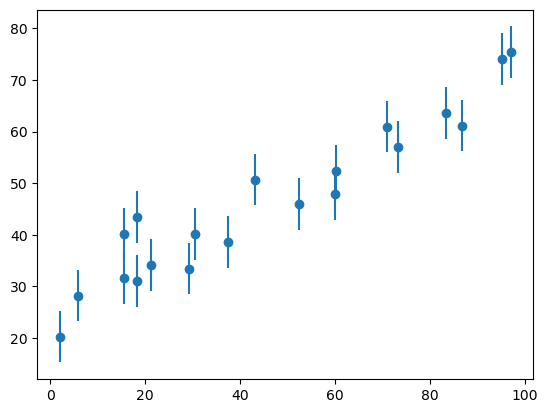

In [2]:
# Function that generates points following a linear trend. 
def make_data(intercept, slope, N=20,sigy=5, rseed=42):
    '''
    Parameters:
    -----------
    intercept, slope: parameters of the linear model
    sigy: width of normally distributed data points around the "true line"
    rseed: Seed of the random number generator (fixed for the sake of discussion)
    Output:
    -------
    x, y, sig_y 
    '''
    rand = np.random.RandomState(rseed)
    x = 100 * rand.rand(N)
    y = intercept + slope * x
    y += sigy * rand.randn(N)
    return x, y, sigy * np.ones_like(x)

theta_true = [25, 0.5]
x, y, sigy = make_data(theta_true[0], theta_true[1], N=20)  # could also be make_data(*theta_true)
plt.errorbar(x, y, sigy, fmt='o')

Let's define the function that calculate the prior. 

In [3]:
def ln_flat_prior(theta):
    '''
    theta = shape(2) array containing the [intercept, slope] = [theta_0, theta_1]
    '''
    if np.abs(theta[1]) < 1000:
        return 0 # log(1)
    else:
        return -np.inf  # log(0)
    
def ln_symmetric_prior(theta):
    '''
    theta = shape(2) array containing the [intercept, slope] = [theta_0, theta_1]
    '''
    if np.abs(theta[1]) < 1000:
        return -1.5 * np.log(1 + theta[1] ** 2)
    else:
        return -np.inf  # log(0)

And the one calculation the (log) likelihood. 

In [4]:
def ln_likelihood(theta, x, y, sigy):
    y_model = theta[0] + theta[1] * x
    return -0.5 * np.sum(np.log(2 * np.pi * sigy ** 2) + (y - y_model) ** 2 / sigy ** 2)

Now a function to evaluate the posterior on a grid of values for the slope and the intercept. 

In [5]:
# Use the cells below to evaluate the log likelihood for each of the two priors above
# Function that returns an array ln(posterior) for a flat/symmetric prior on a grid of values for the slope and intercept
def ln_P(x, y, sigy, slope_limits=[0.3, 0.7], intercept_limits=[15,35], prior_type='flat'):
    '''
    Function to calculate ln(posterior) for a flat prior (prior_type = 'flat') 
    or for a symmetric priot (prior_type='symmetric') 
    **on a grid of values** for the slope and intercept

    Parameters:
    -----------
    x: np.array(npts) - data: x
    y: np.array(npts) - data: y
    sigy: np.array(npts) - data: sigma_y
    slope_limits: list - range of slopes ; default=[0.3, 0.7]
    intercept_limits: list - range of intercepts ; default= [15,35]
    
    Returns: ln(posterior)
    '''
    neval = 100  # number of times I evaluate the posterior for a given parameter
    slope_range = np.linspace(slope_limits[0], slope_limits[1], neval)   # Vector containing 100 sampled values of theta_0 = slope
    intercept_range = np.linspace(intercept_limits[0], intercept_limits[1], neval)  # Vector containing the 100 sampled values of theta_1 = intercept 
    lnP_arr = np.zeros(shape=(neval, neval))  # 2D array where the posteriors will be saved. 

    for i, intercept in enumerate(intercept_range):
        for j, slope in enumerate(slope_range):
            theta = np.array([intercept, slope])

            if prior_type == 'flat':
                lnproba = ln_flat_prior(theta) + ln_likelihood(theta, x, y, sigy)

            if prior_type == 'symmetric':
                lnproba = ln_symmetric_prior(theta) + ln_likelihood(theta, x, y, sigy)
                
            lnP_arr[i, j] = lnproba
    return lnP_arr

In [6]:
# Create the grid of SLOPES/INTERCEPTS values for which you have evaluated ln(posterior) 
# TIP: Use np.meshgrid
slope_limits=[0.1, 1.0]   # [0.3, 0.7]
intercept_limits=[5,50]   # 15, 35
slope_range = np.linspace(slope_limits[0], slope_limits[1], 200)
intercept_range = np.linspace(intercept_limits[0], intercept_limits[1], 200)
SLOPE, INTERCEPT = np.meshgrid(slope_range, intercept_range)

In [7]:
# Function to make calculation and plot in once 
def plot_results(x, y, dy, ax, 
                 slope_limits=(0.1, 1.0),
                 intercept_limits=(5, 50), outcontour = False):
    '''
    Quick function to show the gridded posterior
    Limited docstring
    ax: axis object 
    outcontour: if True, returns ONLY the data needed to plot the contours of the posterior
                slope_range, intercept_range, P2, contour_levels(P2)
    '''
    
    # 1. Evaluate the log probability on the grid (once for each prior)
    slope_range = np.linspace(*slope_limits)    
    intercept_range = np.linspace(*intercept_limits)

    log_P2 = [[ln_likelihood([b, m], x, y, dy) + ln_symmetric_prior([b, m])
               for m in slope_range] for b in intercept_range]

    # For convenience, we normalize the probability density such that the maximum is 1
    P2 = np.exp(log_P2 - np.max(log_P2))

    if outcontour:
        return slope_range, intercept_range, P2, contour_levels(P2)
    
    # 2. Create two subplots and plot contours showing the results
#    fig, ax = plt.subplots(1, 1, figsize=(8, 6),
#                           sharex=True, sharey=True)

    ax.contourf(slope_range, intercept_range, P2, 100, cmap='Blues')
    ax.contour(slope_range, intercept_range, P2, contour_levels(P2), colors='black')
    
    # 3. Add grids and set axis labels
    ax.grid('on', linestyle=':', color='gray', alpha=0.5)
    ax.set_axisbelow(False)
    ax.set_xlabel('slope')
    ax.set_ylabel('intercept')
    ax.plot(theta_true[1], theta_true[0], 'd', color='orange')  # input value when generating data
    
    return ax 

In [8]:
# Function to compute 1, 2, 3-sigma contour levels for a gridded 2D posterior 
# Gaussian assumption for the levels 
def contour_levels(grid):
    """
    Compute 1, 2, 3-sigma contour levels for a gridded 2D posterior
    In 2D - assuming a Gaussian bivariate distribution, 
    the [68, 95, 99.7] levels correspond to [39.3, 86.5, 98.9] contours
    (see V.2.2.4 in Bayes_MCMC.ipynb)
    
    Parameter: 
    ----------
    grid: np.array((n,n)) - 2D grid with the posterior (should be P, NOT ln(P))   
    """
    # In order to calculate the "area around the peak" which encloses a fraction of the total areae
    # we can simply sort the proba from max -> min and search for the area that encloses pct of the total area
    # the method below is "a trick".
    sorted_P = np.sort(grid.ravel())[::-1]   # P ordered from largest to lowest
    pct = np.cumsum(sorted_P) / np.sum(sorted_P)   # Integrated volume from the peak of the 2D PDF array (normalized by the total volume)
    cutoffs = np.searchsorted(pct, np.array([0.989, 0.865, 0.393]))  # cutoffs need to be increasing, i.e. out to in due to function contour 
    return sorted_P[cutoffs]

## Posterior Evolution as data points are acquired

Herebelow, we show the posterior associated to each data point. This illustrates how obtaining even a single data point informs us already about the parameters of the model, and how our knowledge / information about the parameter is being built. The bottom panels shows what happens when combining the posteriors of individual data points each time a new data point is obtained. 

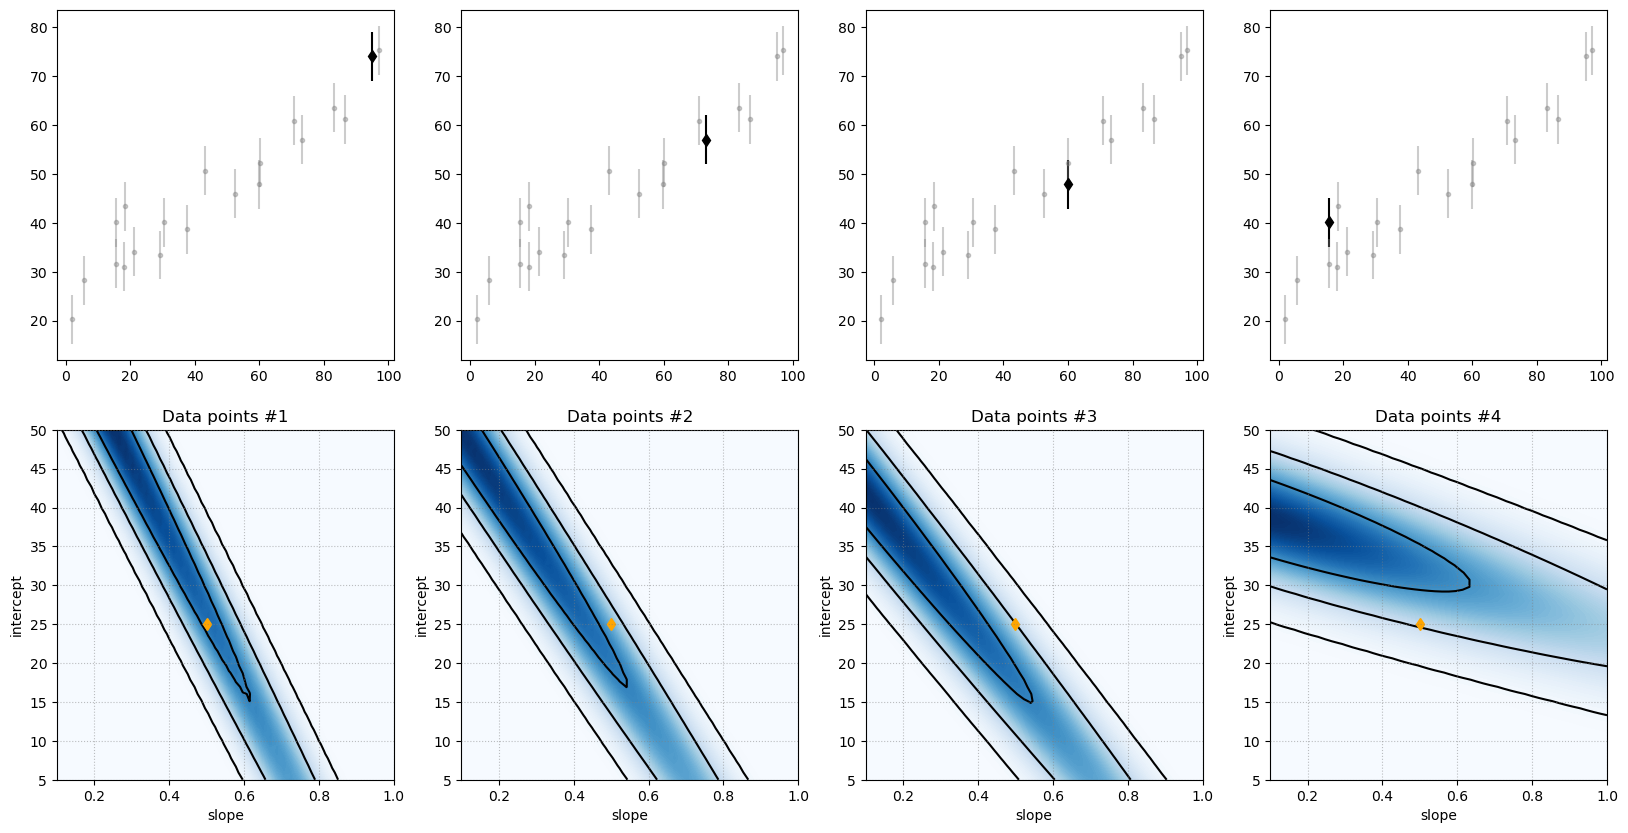

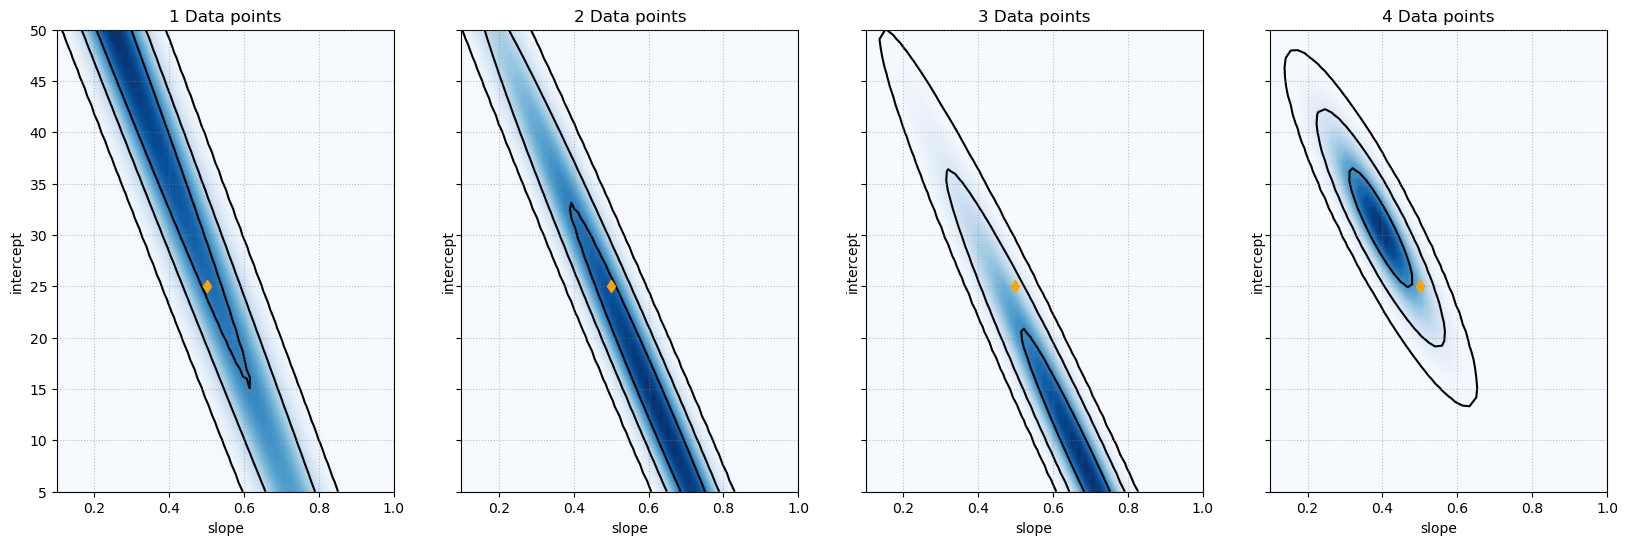

In [16]:
# let's first see the posterior associated to each data point (let's take the points 1, 2, 3, 4)
f, ax = plt.subplots(ncols=4, nrows = 2, figsize=(20, 10))

for i in range(1, 5):
    # Plot data points
    ax[0, i-1].errorbar(x[i:i+1], y[i:i+1], sigy[i:i+1], color='black', marker='d')
    msk = np.arange(len(x)) != i 
    ax[0, i-1].errorbar(x[msk], y[msk], sigy[msk], alpha=0.4, color='grey', ls='', marker='.')
    # plot the posterior
    axx = plot_results(x[i:i+1], y[i:i+1], sigy[i:i+1], ax=ax[1, i-1])
    axx.set_title('Data points #%i' %i)

f, ax = plt.subplots(1, ncols=4, figsize=(20, 6), sharex=True, sharey=True)

# Now, Let's see the posterior evolves when adding points one after the other
for i in range(1, 5):
    axx = plot_results(x[1:i+1], y[1:i+1], sigy[1:i+1], ax=ax[i-1])
    axx.set_title('%i Data points' %i)

Note that the baysian framework shows us that there is effectively information on the model parameters even when we have less data points than degrees of freedom! This makes sense as this data points limits the infinite number of solutions (i.e. the range of solution we would encode as a prior) one would would have without any data point. 

In the frequentist framework, with one data point, we would have a $\chi^2 = 0$ and no possibility to calculate a covariance matrix and say anything about the parameters in a formalised way. The Bayesian framework naturally alleviates this limitation, but beware that the information we have with 1 data point can yet depend substantially on the prior. 

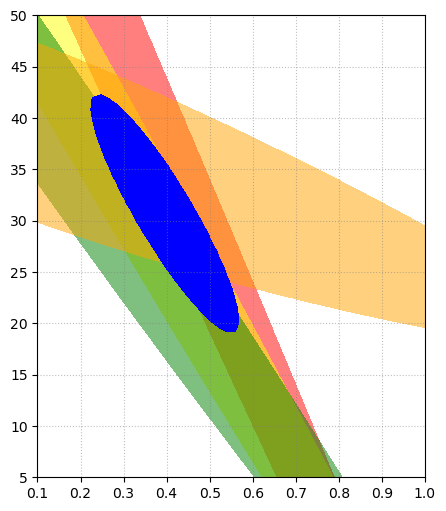

In [17]:
# We can also visualise the 2 sigma contours associated to the 4 points and the joint 2 sigma contours 
# 
f, ax = plt.subplots(1, ncols=1, figsize=(5, 6))

axx.set_title('%i Data points' %i)
color_list = ['red', 'yellow', 'green', 'orange']
for i in range(1, 5):
    slope_range, intercept_range, P2, c_levels = plot_results(x[i:i+1], y[i:i+1], sigy[i:i+1], 
                                                              ax=ax, outcontour=True)
    ax.contourf(slope_range, intercept_range, P2, [c_levels[1], 1], colors=color_list[i-1], alpha=0.5)

i = 4
slope_range, intercept_range, P2, c_levels = plot_results(x[1:i+1], y[1:i+1], sigy[1:i+1], 
                                                              ax=ax, outcontour=True)
#axx = plot_results(x[1:i+1], y[1:i+1], sigy[1:i+1], ax=ax)
ax.contourf(slope_range, intercept_range, P2, [c_levels[1], 1], colors='blue', alpha=1)
    
ax.grid('on', linestyle=':', color='gray', alpha=0.5)

We see that that blue contour (associated to 4 points) is at the "intersection" of the contours of the individual data points. 

Text(0.5, 1.0, '20 Data points')

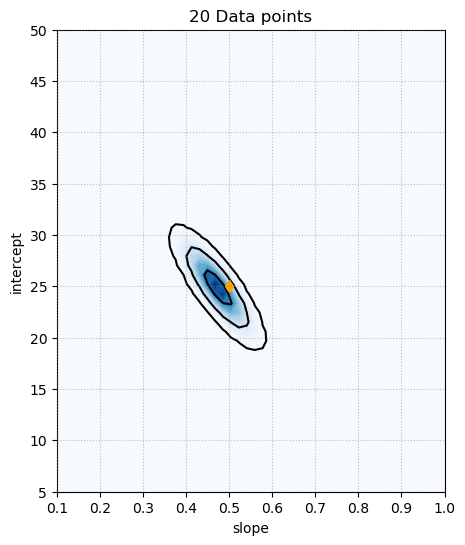

In [18]:
f, ax = plt.subplots(1, ncols=1, figsize=(5, 6))
ax = plot_results(x[0::], y[0::], sigy[0::], ax=ax)
ax.set_title('%i Data points' %20)